<a href="https://colab.research.google.com/github/LisaATaylor/naip-classify/blob/master/SatelliteImageryClassification-BaselineFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Satellite Imagery with Deep Learning
This notebook demonstrates classification of satellite imagery tiles with deep learning using a simple CNN.


The workflow for obtaining and prepping the DeepSat-6 data from Kaggle is presented in [this notebook](https://github.com/LisaATaylor/naip-classify/blob/master/SatelliteImagery_DataPreparation.ipynb).

In [1]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#load data from google drive
from scipy.io import loadmat
data=loadmat('/content/gdrive/My Drive/Springboard/Data/DeepSat6/sat-6-full.mat')

In [0]:
#move data to ndarrays
import numpy as np
import pandas as pd

def fixaxes(inarr): #matlab format has long axis in last position, move to 1st to match tensorflow
  return np.rollaxis(inarr,3,0)

#load ndarrays from mat dictionary
trainX=fixaxes(data['train_x']) 
trainy=data['train_y'].T
testX=fixaxes(data['test_x'])
testy = data['test_y'].T


In [0]:
#make dict for mapping output classification to human-readable name
an=data['annotations']
categories=dict()
for r in range(len(an)):
  categories[r]=an[r][1][0]
#make series of readable training data results
ycat=pd.DataFrame(trainy).idxmax(axis=1).map(categories)

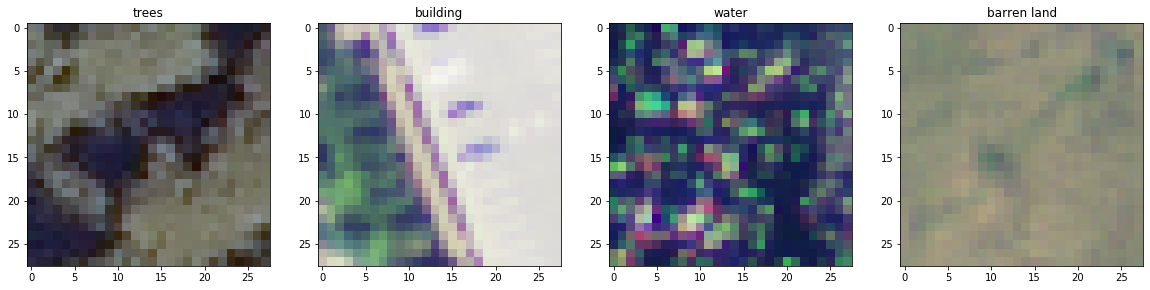

In [4]:
# look at a few tiles, visible bands
import matplotlib.pyplot as plt 
fig,axs=plt.subplots(1,4,figsize=(20,10))
axs[0].imshow(trainX[0,:,:,:3])
axs[1].imshow(trainX[6,:,:,:3])
axs[2].imshow(trainX[2,:,:,:3])
axs[3].imshow(trainX[8,:,:,:3])
axs[0].set_title(ycat.loc[0])
axs[1].set_title(ycat.loc[6])
axs[2].set_title(ycat.loc[2])
axs[3].set_title(ycat.loc[8]);



---
# Implement the CNN architecture with Keras

The data is ready.  Now let's try to classify the image tiles using a simple CNN.


In [0]:
#%load_ext tensorboard
#import datetime
#import tensorflow as tf

#log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
#simple baseline CNN architecture
#input images are 28x28 over 4 bands (R,G,B,IR)

from tensorflow.keras import models,layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28, 4))) #  RGB+IR images.
#model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())  #collapse to 1D
model.add(layers.Dropout(0.5)) #added to reduce overfitting 
model.add(layers.Dense(512,activation='relu')) #reduce after flatten
model.add(layers.Dense(6,activation='softmax')) #final 6-way classification, predict class
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        1184      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [0]:
# Set up an image generator to feed image tiles to the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow(trainX[:280000],trainy[:280000],batch_size=512) #puts 280,000 images in train
val_generator=val_datagen.flow(trainX[280000:],trainy[280000:],batch_size=512) #puts 64,800 records in val

In [0]:
# Compile the model
from tensorflow.keras import optimizers
load_weights=False #if we want to recover the weights without rerunning the model
if load_weights:
    model.load_weights('/content/baseline.hdf5')
model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(lr=0.01),metrics=['accuracy'])

In [14]:
# Fit the model
from keras.callbacks import EarlyStopping
early_stop_mon=EarlyStopping(patience=3)
if load_weights!=True:
    history=model.fit_generator(train_generator,steps_per_epoch=545,epochs=30,validation_data=val_generator,validation_steps=126,callbacks=[early_stop_mon])#,tensorboard_callback])

Epoch 1/30
545/545 [==============================] - 8s 15ms/step - loss: 0.6739 - acc: 0.7367 - val_loss: 0.3137 - val_acc: 0.8734
Epoch 2/30
545/545 [==============================] - 8s 15ms/step - loss: 0.2990 - acc: 0.8746 - val_loss: 0.2621 - val_acc: 0.8824
Epoch 3/30
545/545 [==============================] - 8s 15ms/step - loss: 0.2375 - acc: 0.9044 - val_loss: 0.1955 - val_acc: 0.9192
Epoch 4/30
545/545 [==============================] - 8s 15ms/step - loss: 0.2010 - acc: 0.9208 - val_loss: 0.1680 - val_acc: 0.9326
Epoch 5/30
545/545 [==============================] - 8s 15ms/step - loss: 0.1738 - acc: 0.9318 - val_loss: 0.1469 - val_acc: 0.9411
Epoch 6/30
545/545 [==============================] - 8s 15ms/step - loss: 0.1560 - acc: 0.9384 - val_loss: 0.1369 - val_acc: 0.9433
Epoch 7/30
545/545 [==============================] - 8s 15ms/step - loss: 0.1452 - acc: 0.9422 - val_loss: 0.1224 - val_acc: 0.9507
Epoch 8/30
545/545 [==============================] - 8s 15ms/step - 

In [0]:
save_weights=True
if save_weights:
    model.save_weights('/content/gdrive/My Drive/Springboard/Data/DeepSat6/baseline.hdf5')
    #dump history too
    hist_df=pd.DataFrame.from_dict(history.history)
    hist_df.to_csv('/content/gdrive/My Drive/Springboard/Data/DeepSat6/history.csv')


In [0]:
model.load_weights('/content/gdrive/My Drive/Springboard/Data/DeepSat6/baseline.hdf5')


In [0]:
hist=pd.read_csv('/content/gdrive/My Drive/Springboard/Data/DeepSat6/history.csv')

# Evaluate model fit

In this section, the accuracy and loss values over the course of training are plotted to assess the quality of the model fit and identify potential overfitting.

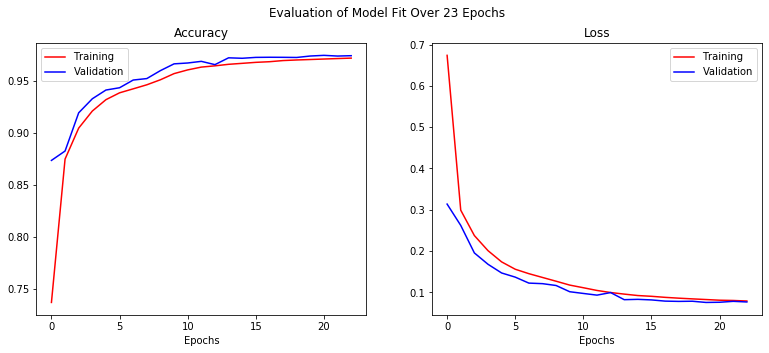

In [15]:
# Plot model fitting
# adapted from Deep Learning With Python (Chollet)
h=history.history
epochs = range(len(h['acc']))
fig,ax=plt.subplots(1,2,figsize=(13,5))
ax[0].plot(epochs, h['acc'], 'r', label='Training')
ax[0].plot(epochs, h['val_acc'], 'b', label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].plot(epochs, h['loss'], 'r', label='Training')
ax[1].plot(epochs, h['val_loss'], 'b', label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.suptitle('Evaluation of Model Fit Over {} Epochs'.format(len(h['acc'])));


In [0]:
#%tensorboard --logdir logs

In [0]:
#try with data augmentation - performed slightly worse than unaugmented data set (results not shown below)
train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=90, #added image augmentation to increase training dataset size
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True,vertical_flip=True) #rescale to [0,1]

train_generator_aug=train_datagen_aug.flow(X[:16000],y.values[:16000],batch_size=64)

# Evaluate held-out data

The trained model is used to predict classes for held-out data that hasn't been used to train the model.  Various methods are used to evaluate the performance of the model. 

In [0]:
# Look at predictions on held-out data
testX_rescaled=testX/255
predy=model.predict(testX_rescaled)

In [0]:
#get pd Series of predicted and actual categories for test dataset
testycat=pd.DataFrame(testy).idxmax(axis=1).map(categories) #actual
testycat_pred=pd.DataFrame(predy).idxmax(axis=1).map(categories) #pred

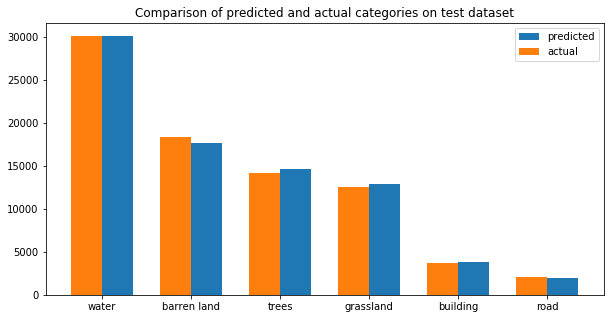

In [18]:
#Plot results
pred_df=testycat_pred.value_counts()
act_df=testycat.value_counts()
fig,ax=plt.subplots(figsize=(10,5))
ind=np.arange(6)
width=0.35
pred=ax.bar(ind+width,pred_df.values,width=width,label='predicted')
act=ax.bar(ind,act_df.values,width=width,label='actual')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(pred_df.index)
ax.legend()
ax.set_title('Comparison of predicted and actual categories on test dataset');

In [19]:
#get prediction errors
compare_df=pd.concat([testycat,testycat_pred],axis=1)
compare_df.columns=['actual','predicted']
compare_df=compare_df.assign(mismatch=compare_df.actual!=compare_df.predicted)
compare_df.loc[compare_df.mismatch].head()

,actual,predicted,mismatch
37,barren land,grassland,True
92,barren land,grassland,True
102,building,water,True
105,grassland,trees,True
152,road,building,True


In [20]:
compare_df['mismatch'].value_counts()

False    78965
True      2035
Name: mismatch, dtype: int64

In [21]:
#accuracy on test dataset
print('Overall accuracy on test dataset: {0:.3f}'.format(1-(compare_df.mismatch.sum()/compare_df.mismatch.count())))

Overall accuracy on test dataset: 0.975


In [48]:
# Look at confusion matrix, classification report
from sklearn.metrics import classification_report,confusion_matrix
print('Classification Report:')
print(classification_report(testycat,testycat_pred))
#print('Confusion Matrix:')
#print(confusion_matrix(testycat,testycat_pred))
#print('\nNumber of Correct Classifications:')
#correct=compare_df.loc[~compare_df.mismatch].groupby(['actual','predicted']).count()
#correct.columns=['Correct']
#print(correct) #check order of entries in confusion matrix

Classification Report:
              precision    recall  f1-score   support

 barren land       0.99      0.95      0.97     18367
    building       0.95      0.97      0.96      3714
   grassland       0.93      0.95      0.94     12596
        road       0.93      0.87      0.90      2070
       trees       0.97      0.99      0.98     14185
       water       1.00      1.00      1.00     30068

    accuracy                           0.97     81000
   macro avg       0.96      0.96      0.96     81000
weighted avg       0.98      0.97      0.97     81000



In [47]:
#confusion matrix pretty print (copied from https://gist.github.com/zachguo/10296432)
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()
print_cm(confusion_matrix(testycat,testycat_pred),labels=correct.index.get_level_values(0).values)

                barren land    building   grassland        road       trees       water 
    barren land     17480.0         7.0       841.0         9.0        30.0         0.0 
       building         1.0      3598.0         1.0       101.0         2.0        11.0 
      grassland       223.0         0.0     11910.0        32.0       431.0         0.0 
           road         3.0       180.0        38.0      1800.0        10.0        39.0 
          trees         2.0         0.0        74.0         0.0     14109.0         0.0 
          water         0.0         0.0         0.0         0.0         0.0     30068.0 


In [23]:
# roads have slightly lower recall comparted to other categories (often misclassified as buildings)
# get indices of misclassifications of roads
road_mismatch=compare_df.loc[(compare_df.mismatch)&(compare_df.actual=='road')]
print(road_mismatch['predicted'].value_counts()) #roads most often misclassified as buildings
road_mismatch['ixcopy']=road_mismatch.index
mismatches=road_mismatch.groupby('predicted')['ixcopy'].first()

building       180
water           39
grassland       38
trees           10
barren land      3
Name: predicted, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


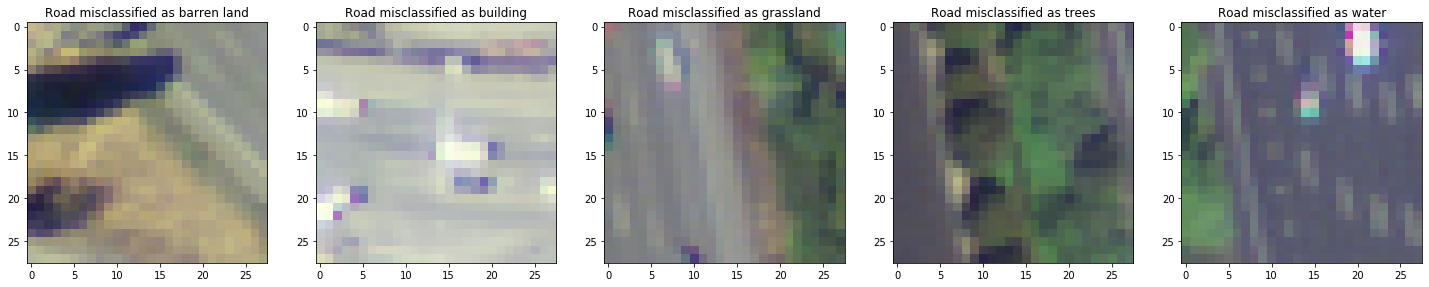

In [24]:
#view some mismatches
fig,axs=plt.subplots(1,5,figsize=(25,10))
axix=0
for i,v in mismatches.iteritems():
  axs[axix].imshow(testX[v,:,:,:3])
  axs[axix].set_title('Road misclassified as {}'.format(i))
  axix+=1

# Make predictions on new NAIP data
In this section, I create image tiles from a new NAIP dataset (not part of DeepSat6)and classify it using the CNN.  The classifications are re-formed into a grid for comparison to the original image.

In [25]:
!pip install rasterio

     |████████████████████████████████| 15.2MB 98kB/s 


In [0]:
import rasterio as rio
from rasterio.windows import Window
import os

In [0]:
imgdir=r'/content/gdrive/My Drive/Springboard/Data/NAIP'
files=os.listdir(imgdir)
psfile=os.path.join(imgdir,files[1])

In [0]:
#open raw jpeg and subset it to a desired window extent
with rio.open(psfile) as src:
  psimg=src.read(window=Window(6000,8000,3000,3000))#(0,1000,3000,3000))

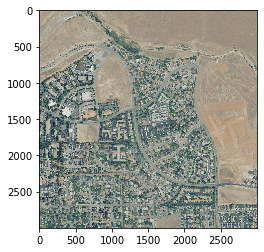

In [29]:
#view image
plt.imshow(np.rollaxis(psimg,axis=0,start=3)[:,:,:3])

In [0]:
#function to make tiles from the image
def make_naip_tiles(bigimg,tilesize):
  bigimg=np.rollaxis(bigimg,axis=0,start=3)#redim raw image
  width,height,bands=bigimg.shape
  ntile_y=np.int(np.floor(width/tilesize))
  ntile_x=np.int(np.floor(height/tilesize))
  ntiles=ntile_x*ntile_y
  startix=0
  reshaped=np.empty((ntiles,tilesize,tilesize,bands))
  for xi in range(ntile_x):
    xl=tilesize*xi
    xr=xl+tilesize
    for yi in range(ntile_y):
      yl=tilesize*yi
      yr=yl+tilesize
      reshaped[startix]=bigimg[xl:xr,yl:yr,:]
      startix+=1
  return reshaped

In [31]:
#reshape the source image
rs=make_naip_tiles(psimg,28)
rs.shape

(11449, 28, 28, 4)

In [0]:
#input to CNN and predict classes
newimg=rs/255
pred_new_y=model.predict(newimg)

In [0]:
#get pd Series of predicted categories of unseen data
newycat=pd.DataFrame(pred_new_y).idxmax(axis=1).map(categories) #actual


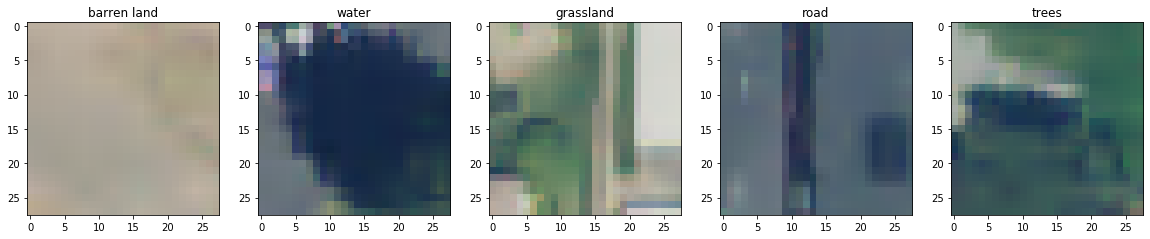

In [34]:
#inspect a few tile predictions
fig,axs=plt.subplots(1,5,figsize=(20,10))
ixs=[1000,3857,8000,9202,10079]
for i in range(5):
  axs[i].imshow(rs[ixs[i],:,:,:3].astype(int))
  axs[i].set_title(newycat.iloc[ixs[i]])


In [35]:
#reassemble classified image - is it what we expect?
catix=pd.DataFrame(pred_new_y).idxmax(axis=1)
catix.value_counts()

1    5141
3    2422
4    2331
2    1137
0     415
5       3
dtype: int64

In [0]:
n_xtiles=np.sqrt(rs.shape[0])
n_ytiles=n_xtiles
tile_size=28

In [0]:
#use pandas to reshape and pivot results (convert this workflow to numpy)
newdf=pd.DataFrame(catix,columns=['Class'])
newdf['ix1']=newdf.index
newdf['row']=newdf.ix1.apply(lambda x:np.floor(x/n_xtiles))
newdf['col']=newdf.ix1.apply(lambda x:np.mod(x,n_xtiles))
pivimg=newdf.pivot('row','col','Class').to_numpy()

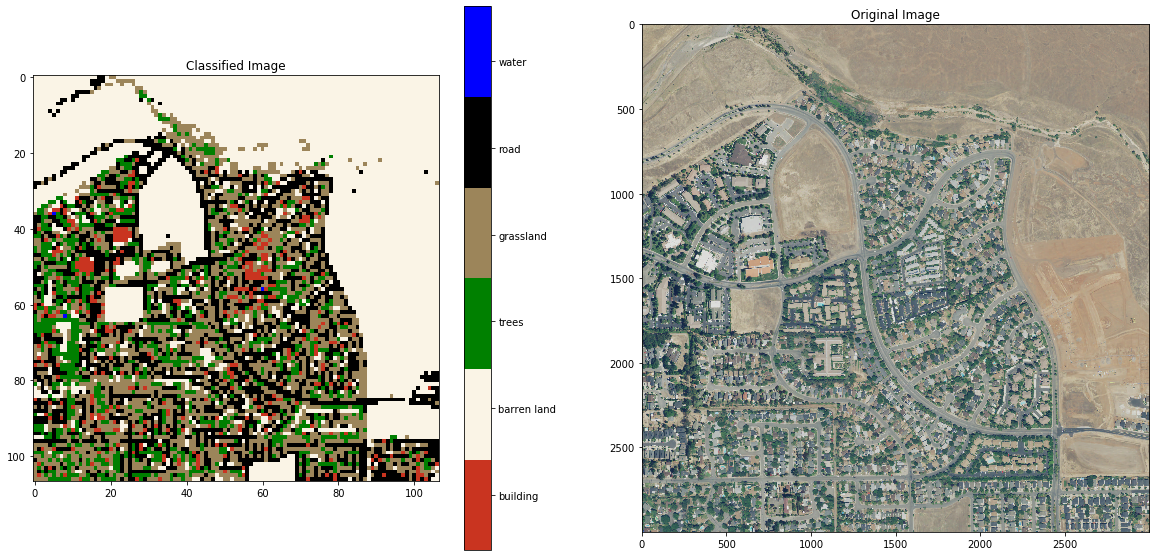

In [38]:
#look at results
from matplotlib.colors import ListedColormap
cmap=ListedColormap(['#c93420','#faf4e6','g','#9c855a','k','b'])#custom colormap
fig,axs=plt.subplots(1,2,figsize=(20,10))
im=axs[0].imshow(pivimg,cmap=cmap)
cb=fig.colorbar(im, ax=axs[0])
cb.set_ticks(np.linspace(0.5,4.5,6))
cb.ax.set_yticklabels([categories[i] for i in range(6)])

axs[1].imshow(np.rollaxis(psimg,axis=0,start=3)[:,:,:3])
axs[0].set_title('Classified Image')
axs[1].set_title('Original Image');